# Test Notebook to visualize the data and start playing around

## Libraries

In [1]:
import pandas as pd
import numpy as np
import math
%matplotlib inline
from matplotlib import pyplot as plt
import random
random.seed(1)
from sklearn.preprocessing import normalize

## Importing the data set
Our dataset contains images of the **HAM10000** dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions.

In [2]:
# IMPORTANT: Filepath depends on OS!
df = pd.read_csv(r'data/hmnist_28_28_L.csv')
print(df) # Shape (#images, h*w+1) (here: (10015, 785))

       pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0            169        171        170        177        181        182   
1             19         57        105        140        149        148   
2            155        163        161        167        167        172   
3             25         71        116        139        136        153   
4            129        162        181        196        205        208   
...          ...        ...        ...        ...        ...        ...   
10010        172        171        173        175        164        187   
10011          2         34        108        116        114        119   
10012        122        154        162        170        179        197   
10013        137        143        141        139        147        152   
10014        149        157        157        152        151        152   

       pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel0775  pixel0776  \
0            181   

## Displaying a data image

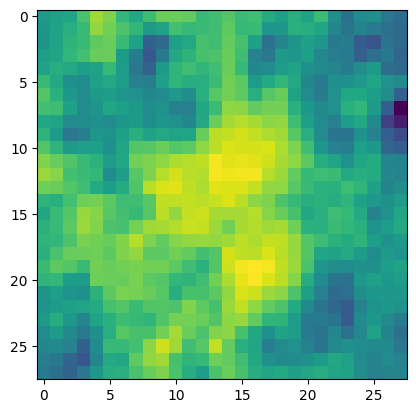

In [52]:
def disp_img(data_vec):
    # Handle the cases of whether the label for an image is provided or not
    if math.sqrt(np.size(data_vec)) != int(math.sqrt(np.size(data_vec))):
        img_label = data_vec[-1]
        img_vec = data_vec[0:-1]
    else:
        img_vec = data_vec

    size = np.size(img_vec)
    dimension = int(math.sqrt(size))

    img_mat = np.reshape(np.array(img_vec), (dimension, dimension))

    plt.imshow(img_mat)
    plt.show()


img_number = 9869 # Index of a particular data image
data_vec = df.loc[img_number]

disp_img(data_vec)

# Count occurences of labels
Count the number of data images corresponding to each label.

In [4]:
label = df['label']
uniq_label, counts_label = np.unique(label, return_counts=True)

# Each tuple will contain a label and the number of images with the same label
# [(label, #occurences), ..]
occurences = list(zip(uniq_label, counts_label))
print(occurences)

[(0, 327), (1, 514), (2, 1099), (3, 115), (4, 6705), (5, 142), (6, 1113)]


# Importing metadata
This metadata file contains additional information about the patients for each data image (e.g. age, sex, body part where the image has been taken).

In [5]:
# IMPORTANT: Filepath depends on OS!
df_meta = pd.read_csv(r'data/HAM10000_metadata.csv')
print(df_meta)

         lesion_id      image_id     dx dx_type   age     sex localization
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear
...            ...           ...    ...     ...   ...     ...          ...
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back

[10015 rows x 7 columns]


# The various diagnostic categories
The labels/numbers represent the following diagnostic categories:

**0)** Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec)

**1)** basal cell carcinoma (bcc)

**2)** benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl)

**3)** dermatofibroma (df)

**4)** melanoma (mel)

**5)** melanocytic nevi (nv)

**6)** vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc)

In [6]:
cath = df_meta['dx']
uniq_cath, counts_cath = np.unique(cath, return_counts=True)

diagnoses = list(zip(uniq_cath, counts_cath))
print(diagnoses)

[('akiec', 327), ('bcc', 514), ('bkl', 1099), ('df', 115), ('mel', 1113), ('nv', 6705), ('vasc', 142)]


# Partition the images into the different classes
Create a list of nested lists. Each nested list represents a label and contains the indices of all data images with the same label. E.g. img_index_group[2] contains all images for label 2.

In [7]:
# List of 7 nested lists (for each diagnostical categorie)
# The ith nested list contains the indices of all images, which correspond to label i
# E.g. img_index_group[2] contains all images for label 2
img_index_group = []

for i in range(len(uniq_label)):
    img_index_group.append([])
    for j in range(df.shape[0]):
        if df['label'][j] == i:
            img_index_group[i].append(j)

# Output would exceed the size limit
# print(img_index_group)

# For debugging purposes
# print(list((i, len(img_index_group[i])) for i in range(len(img_index_group))))

# Splitting into training and testing data

In [8]:
training_split = 0.9                #Percentage of Data used for training
img_index_group_split = []          #Same as img_index_group but every nested list is split into two lists: first is list for training, second is list for testing

for i in range(len(img_index_group)):
    random.shuffle(img_index_group[i])
    split_point = round(len(img_index_group[i])*training_split)
    img_index_group_split.append([img_index_group[i][:split_point], img_index_group[i][split_point:]])
    
    #print(i)
    #print(len(img_index_group_split[i][0]))
    #print(len(img_index_group_split[i][1]))

#print(img_index_group_split)

# Running Clustering on the different diagnosis

## Principal Component Analysis

Corresponding to HW4 Question E, find reference for Steps in the posted Solution

### Computing Mean of each diagnostics cathegory

Corresponding E.2

In [9]:
mean = []

for i in range(len(img_index_group)):
    mean.append(np.mean(df.loc[img_index_group[i]], axis=0))
    
    #disp_img(mean[i])
    #print(mean[i])


### Substracting Mean for each diagnostic cathegory from the data of that cathegory

Corresponding E.3

In [10]:
df_sub_mean = pd.DataFrame()
for i in range(len(img_index_group)):
    df_sub_mean = pd.concat((df_sub_mean, df.loc[img_index_group[i]]-mean[i]))

df_sub_mean.sort_index(axis=0, inplace=True)

#print(df_sub_mean)

### Calculating the Eigenvalues and Eigenvectores for each cathegory

Corresponding E.4

In [11]:
df_matrix = df_sub_mean.iloc[:, :-1]

eig_vec = []
eig_val = []

for i in range(len(img_index_group)):
    matrix = df_matrix.loc[img_index_group[i]]
    val, vec = np.linalg.eig(matrix.transpose().dot(matrix))
    eig_val.append(val)
    eig_vec.append(vec)

print(eig_val)
print(eig_vec)


[array([ 6.50774501e+07+0.00000000e+00j,  2.34687085e+07+0.00000000e+00j,
        1.54681273e+07+0.00000000e+00j,  7.85415670e+06+0.00000000e+00j,
        6.41630418e+06+0.00000000e+00j,  4.76621781e+06+0.00000000e+00j,
        4.22550353e+06+0.00000000e+00j,  3.98356738e+06+0.00000000e+00j,
        3.13270569e+06+0.00000000e+00j,  2.61939698e+06+0.00000000e+00j,
        1.86409499e+06+0.00000000e+00j,  1.81382840e+06+0.00000000e+00j,
        1.68660688e+06+0.00000000e+00j,  1.53125803e+06+0.00000000e+00j,
        1.46567484e+06+0.00000000e+00j,  1.32175500e+06+0.00000000e+00j,
        1.21896645e+06+0.00000000e+00j,  1.07275685e+06+0.00000000e+00j,
        1.02179453e+06+0.00000000e+00j,  9.78382837e+05+0.00000000e+00j,
        9.17059354e+05+0.00000000e+00j,  8.11285481e+05+0.00000000e+00j,
        7.87531435e+05+0.00000000e+00j,  7.68096204e+05+0.00000000e+00j,
        7.45919821e+05+0.00000000e+00j,  6.99716535e+05+0.00000000e+00j,
        6.67475305e+05+0.00000000e+00j,  6.6109674

### Sorting the Eigenvectors acording to the size of their corresponding Eigenvalues

Corresponding E.5

In [15]:
for i in range(len(img_index_group)):
    idx = eig_val[i].argsort()[::-1]
    eig_val[i] = eig_val[i][idx]
    eig_vec[i] = eig_vec[i][:, idx]

## Finishing Calculation and normalization of real EV 

Corresponding E.6 and E.7


// This is where it goes wrong for some reason, the resulting eigenvector matrix sould be square but it isnt

In [32]:
eig = []

for i in range(len(img_index_group)):
    eig_cath = df_matrix.loc[img_index_group[i]].dot(eig_vec[i])
    eig_cath = eig_cath.applymap(np.absolute)
    eig.append(normalize(eig_cath, norm='l2', axis=0))

print(eig_cath)

             0            1           2           3           4           5    \
1422   12.053036    55.908289  289.765135   29.335627   56.207738   76.823415   
1434  203.517600    92.173879  110.371690  103.954821   73.485683  144.187735   
1897   28.005801    92.497002  807.841176  346.563189  384.444572  448.961918   
1866  194.462216    29.566598  220.120270  113.215898    1.976189   96.880031   
2036  346.750416   194.766450  277.959784  362.860104  228.893483  635.489370   
...          ...          ...         ...         ...         ...         ...   
1278  807.217997   113.069512  244.085941  389.239297   69.725456   66.225708   
1589   73.507508   258.977911    8.257350    9.768286  168.172082  122.892431   
2023  158.771825   260.126808  205.867227  127.182838  211.030466  203.845551   
1928  534.495124  1331.307055  242.277802  213.170157  168.260210   37.401197   
2209  631.456024   220.363070  262.667302   14.648106  113.071648  221.435892   

             6           7 

// to try to fix the dimensions which are wrong from the previous step i added this which essentially does a similar thing as the previous step again and therefore computes matrices of the right dimensions. Unfortunately the numbers did not magically turn out to be right

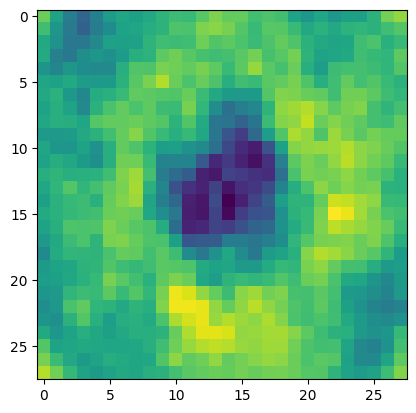

(784, 784)


In [89]:
pc = []
for i in range(len(img_index_group)):
    pc.append(eig[i].transpose().dot(df_matrix.loc[img_index_group[i]]))

disp_img(pc[0][0])

## Calculating of Principal Components C

Corresponding to F

This is not adapted to all the cathegories yet since it doesnt even work for one image yet

// This does not provide the right result, i "fixed" the math to the point where the dimensions are right (with the help of the previous step), but in the plotted picture you can see its incorrect. It should show the (reconstructed) first images but shows ??

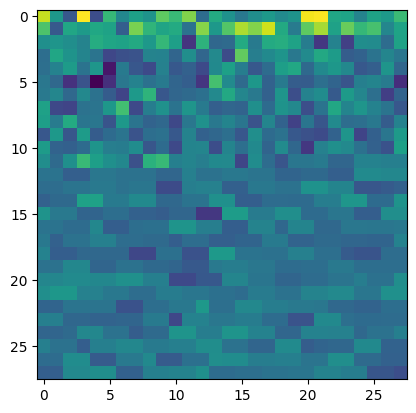

In [96]:
c = pc[0].dot(df_matrix.loc[img_index_group[0]].transpose())

z = eig[0].transpose().dot(c[0]) + mean[0][:-1]

disp_img(z)

#This is the code to loop over the cathegories, if the above test for a single image works add the changes here and uncomment to calculate for all
#C = []
#for i in range(len(img_index_group)):
#    C.append(pc[i].dot(df_matrix.loc[img_index_group[0]].transpose()))

## Trying PCS with only one cathegory to simplify

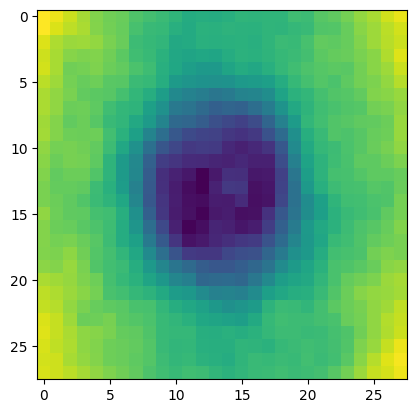

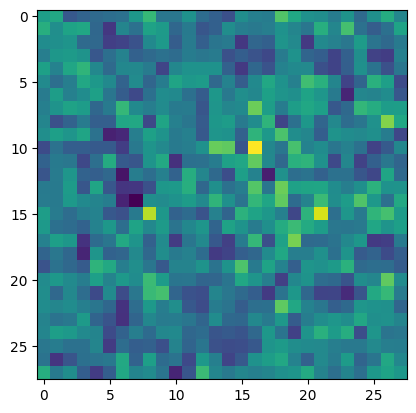

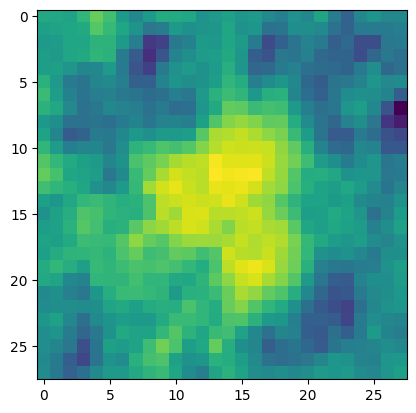

In [53]:
data = df_matrix.loc[img_index_group[0]]
#data = data.transpose()
#print("Data")
#print(data)

mean_1 = np.mean(data, axis=0)
#print("Mean")
#print(mean_1)

data_submean = data - mean_1
data_submean = data_submean.transpose()
#print("Data sub mean")
#print(data_submean)

eval, evec = np.linalg.eig(data_submean.transpose().dot(data_submean))
#print("EW")
#print(eval)
#print(eval.shape)
#print("EV")
#print(evec)
#print(evec.shape)

idx = eval.argsort()[::-1]
eval = eval[idx]
evec = evec[:, idx]
#print("EW sorted")
#print(eval)
#print(eval.shape)
#print("EV sorted")
#print(evec)
#print(evec.shape)

U = data_submean.dot(evec)
#print("U")
#print(U)
#print(U.shape)

U = normalize(U, norm='l2', axis=0)
#print("Unorm")
#print(U.shape)
#print(U)

C = evec.dot(data_submean.transpose()).transpose()
#print("C")
#print(C)
#print(C.shape)

disp_img(U[:, 0])

z = U.dot(C[0]) + mean_1

disp_img(z)

disp_img(data.iloc[0])

